<h1 style="font-size: 40px; margin-bottom: 0px;">Week 15 Assignment</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

<h1 style="color:#FF0000;"><strong><u>KEY</u></strong></h1>

<strong><u>Due: Saturday, December 13th at 11:59PM</u></strong>

<strong><u>Total points: 5 pts</u></strong>

<strong><u>To turn in your assignment:</u></strong>
<ol>
    <li>Complete assignment and make sure you have all the outputs requested for the notebook. <mark><strong>Switch between R and Python kernels as needed to complete each question.</strong></mark></li>
    <li>Go to your server's file directory and locate the <code>week_15_homework</code> directory containing this notebook</li>
    <li>Right click and select <strong>Download as an Archive</strong> to download the <code>week_15_homework</code> directory as a ZIP folder. Do not mix up with <strong>Download Current Folder as an Archive</strong></li>
    <li>Upload your ZIP folder to your individual feedback Google Drive folder under <code>MCB201B</code></li>
</ol>

<strong><u>How this assignment will be graded:</u></strong>

You will be graded on whether or not you have <u>all requested outputs</u> and if your output is correct. You will also be graded on if your code is expected to be able to run without errors. There can be more than one correct way to answer a question. If you find that you prefer to separate your answer for a single question into multiple code cells, feel free to do so.

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

<h1>Question 1</h1>

1pt

Run a differential expression analysis on the full class transcriptome dataset, and export the results table as a <code>.csv</code> file to be included in your homework submission. Export shrunken logfold change results and normalized counts as needed for the other parts of this homework.

Perform hierarchical clustering analysis on the top 500 most variably expressed genes for the full class transcriptome dataset. Output the results of your hierarchical clustering analysis to a PDF file to be included in your homework submission.

In [1]:
library(DESeq2)
library(ggplot2)
library(pheatmap)
library(viridis)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb



In [2]:
counts <- read.csv('/home/jovyan/Instructor/full-rna-backup/counts/class-set/1M_counts_matrix.csv',
                   stringsAsFactors=FALSE,
                   row.names=1
                   )

conditions <- read.csv('/home/jovyan/Instructor/full-rna-backup/counts/class-set/1M_conditions_matrix.csv',
                       stringsAsFactors=FALSE,
                       row.names=1
                       )

means <- apply(counts, 1, mean)
counts <- counts[which(means>0), ]

dds <- DESeqDataSetFromMatrix(countData = counts,
                              colData = conditions,
                              design = ~ condition
                              )

dds <- estimateSizeFactors(dds)
norm.counts <- counts(dds, normalized=TRUE)
write.csv(norm.counts, './norm_counts.csv')

dds <- estimateDispersions(dds)
dds <- nbinomWaldTest(dds)
res <- results(dds)
write.csv(res, './results.csv')
resLFC <- lfcShrink(dds, 
                    coef='condition_tazko_vs_control'
                    )
write.csv(resLFC, './results_lfcShrink.csv')

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



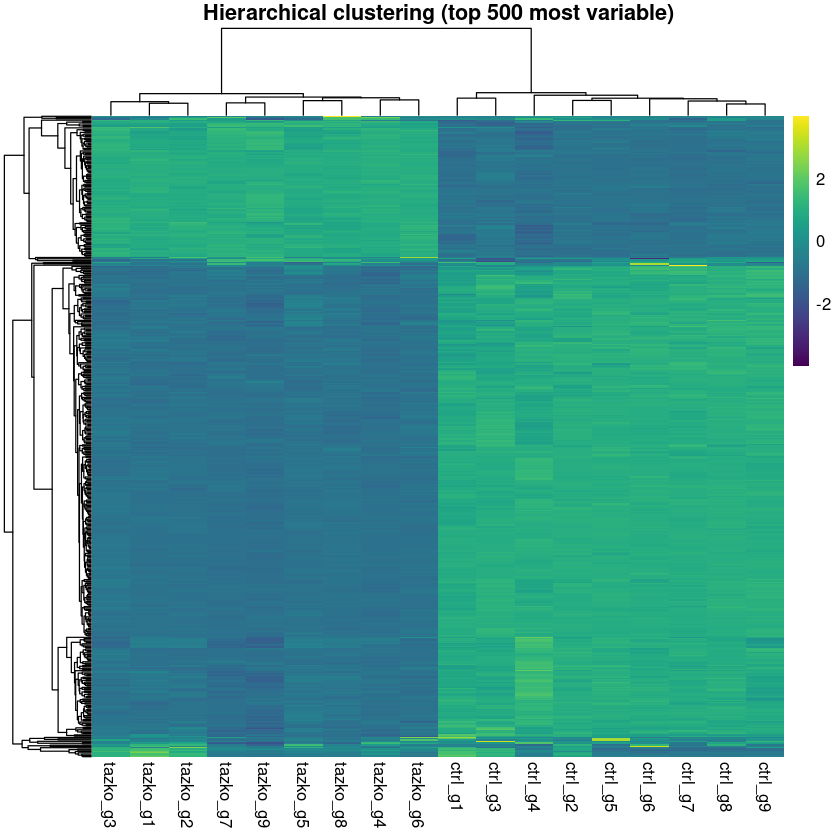

In [3]:
rld <- rlog(dds, blind=FALSE)
rld.values <- assay(rld)
top500.var.rld <- head(rld.values[order(rowVars(rld.values), decreasing=TRUE), ], 500)
pheatmap(top500.var.rld,
         color=viridis(255),
         scale='row',
         show_rownames=FALSE,
         main='Hierarchical clustering (top 500 most variable)',
        )

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

<h1>Question 2</h1>

1pt

Generate an MA plot (either using R or Python) to visualize the results of your differential expression analysis. Export into a PDF file to be included as part of this homework submission.

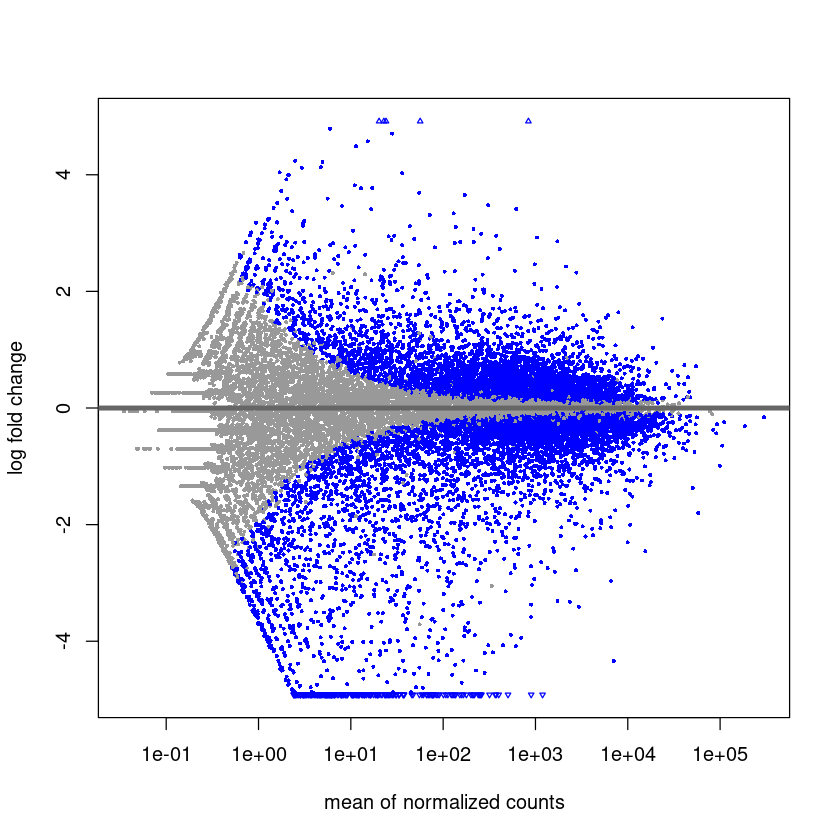

In [4]:
plotMA(res)

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

<h1>Question 3</h1>

1pt

Run an over-representation analysis for the Hallmark gene sets on the full class results for the following "interesting" hits: genes that are at least 2-fold upregulated in TAZ KO cells compared to controls and are significant (p-adj < 0.05). Generate a dot-plot of the top 5 functional groups based on their significance (Adjusted P-value < 0.05) with the Combined Score values plotted along the x-axis.

In [1]:
pip install gseapy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import gseapy as gp
import os

In [3]:
norm_counts = pd.read_csv('./norm_counts.csv')
shrinklfc = pd.read_csv('./results_lfcShrink.csv')

In [4]:
norm_counts.rename(columns={norm_counts.columns[0] : 'gene'},
                   inplace=True
                  )

shrinklfc.rename(columns={shrinklfc.columns[0] : 'gene'},
                 inplace=True
                )

In [5]:
msig = gp.Msigdb()
hallmark_db = msig.get_gmt(category='h.all', dbver='2025.1.Hs')

In [6]:
sig_genes = shrinklfc.loc[(shrinklfc.padj < 0.05) & (shrinklfc.log2FoldChange >= 1), :]
bg_genes = shrinklfc.loc[~pd.isna(shrinklfc.padj), 'gene'].to_list()

ora = gp.enrich(gene_list=sig_genes.gene.to_list(),
                gene_sets=hallmark_db,
                background=bg_genes,
                outdir=None,
               )

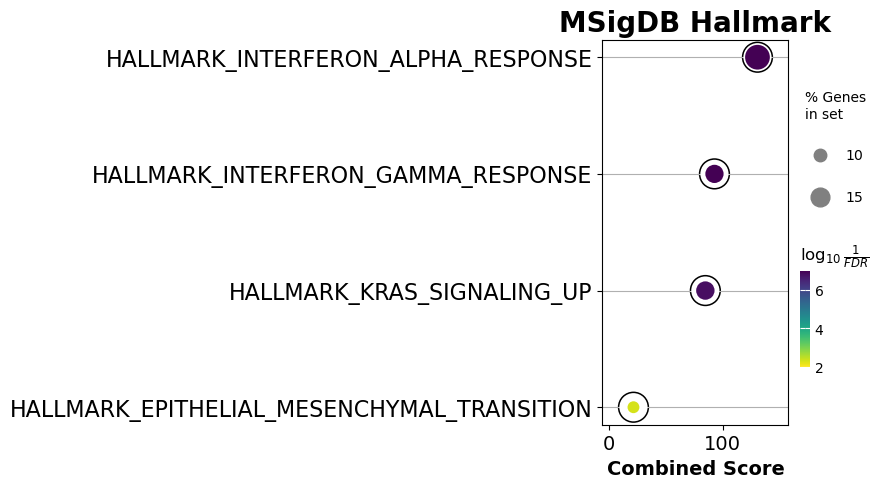

In [7]:
gp.dotplot(df=ora.res2d,
           column='Adjusted P-value',
           x='Combined Score',
           y='Term',
           top_term=25,
           cutoff=0.05,
           size=15,
           figsize=(3,5),
           title='MSigDB Hallmark',
           xticklabels_rot=0,
           show_ring=True,
           marker='o',
          );

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

<h1>Question 4</h1>

1pt

Perform GSEA on the full class transcriptome dataset with the Hallmark gene sets, and generate a dot-plot of the top 5 functional groups enriched in TAZ KO samples based on their NES.

In [8]:
ctrl = 'CONTROL'
tazko = 'TAZ KO'
class_vector = ([ctrl] + [tazko])*9

gs_res = gp.GSEA(data=norm_counts,                  
                 gene_sets=hallmark_db,             
                 classes=class_vector,              
                 method='signal_to_noise',          
                 permutation_type='phenotype',      
                 permutation_num=1000,              
                 outdir=None,                       
                 seed=135,                         
                )

gs_res.pheno_pos = tazko
gs_res.pheno_neg = ctrl

gs_res.run()

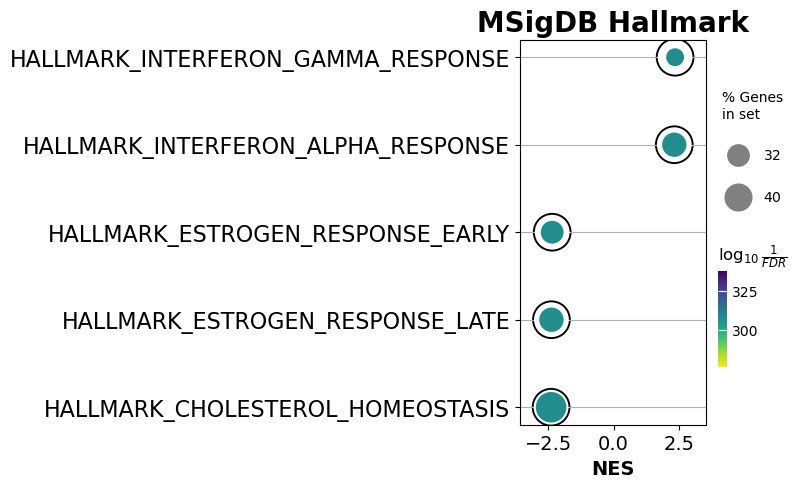

In [9]:
gp.dotplot(df=gs_res.res2d,
           column='FDR q-val',
           x='NES',
           y='Term',
           top_term=5,
           cutoff=0.25,
           size=8,
           figsize=(3, 5),
           title='MSigDB Hallmark',
           xticklabels_rot=0,
           show_ring=True,
           marker='o',
          );

Pull out the leading edge genes for the top functional group enriched in TAZ KO samples, and generate a heatmap to compare the normalized counts of leading edge genes for that functional group.

In [10]:
gs_res.res2d.sort_values(by='NES', ascending=False, inplace=True)

In [11]:
gs_res.res2d

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
2,gsea,HALLMARK_INTERFERON_GAMMA_RESPONSE,0.448687,2.356028,0.0,0.0,0.0,51/190,7.15%,IFIT3;HERC6;IFIT1;RSAD2;IFI44;TRIM21;OAS2;IFIH...
4,gsea,HALLMARK_INTERFERON_ALPHA_RESPONSE,0.615472,2.324961,0.0,0.0,0.0,35/96,7.26%,IFIT3;HERC6;RSAD2;IFI44;TRIM21;IFIH1;IFIT2;OAS...
10,gsea,HALLMARK_KRAS_SIGNALING_UP,0.409175,2.023616,0.0,0.001713,0.011,57/181,11.18%,GFPT2;EMP1;TNFRSF1B;ANKH;ANGPTL4;SATB1;PLAT;LC...
13,gsea,HALLMARK_IL2_STAT5_SIGNALING,0.399747,1.975221,0.0,0.002075,0.017,43/189,8.24%,EMP1;TNFRSF1B;SPRY4;PRNP;SNX9;CA2;GBP4;IL4R;GA...
28,gsea,HALLMARK_APICAL_SURFACE,0.404104,1.718651,0.005882,0.024114,0.154,11/40,6.35%,SRPX;CX3CL1;MDGA1;PLAUR;GSTM3;SHROOM2;TMEM8B;D...
35,gsea,HALLMARK_TGF_BETA_SIGNALING,0.389077,1.457413,0.092929,0.138027,0.533,18/54,13.03%,PMEPA1;SLC20A1;LTBP2;SMAD7;ACVR1;BCAR3;CDK9;SE...
39,gsea,HALLMARK_BILE_ACID_METABOLISM,0.306625,1.387767,0.037736,0.169755,0.635,37/106,17.60%,PHYH;CAT;PFKM;CH25H;BCAR3;RETSAT;PEX7;ABCG4;PE...
44,gsea,HALLMARK_NOTCH_SIGNALING,0.331504,1.239811,0.221095,0.276466,0.83,7/31,9.28%,FZD1;WNT5A;ST3GAL6;NOTCH3;CUL1;PSEN2;FBXW11
45,gsea,HALLMARK_KRAS_SIGNALING_DN,0.250035,1.192442,0.15914,0.291119,0.881,36/141,18.04%,RSAD2;TCF7L1;KRT15;CAMK1D;ABCG4;C5;P2RX6;PDK2;...
46,gsea,HALLMARK_PANCREAS_BETA_CELLS,0.344311,1.154382,0.256167,0.299087,0.91,3/26,2.02%,MAFB;FOXO1;ELP4


In [12]:
genes = gs_res.res2d.Lead_genes[2].split(';')

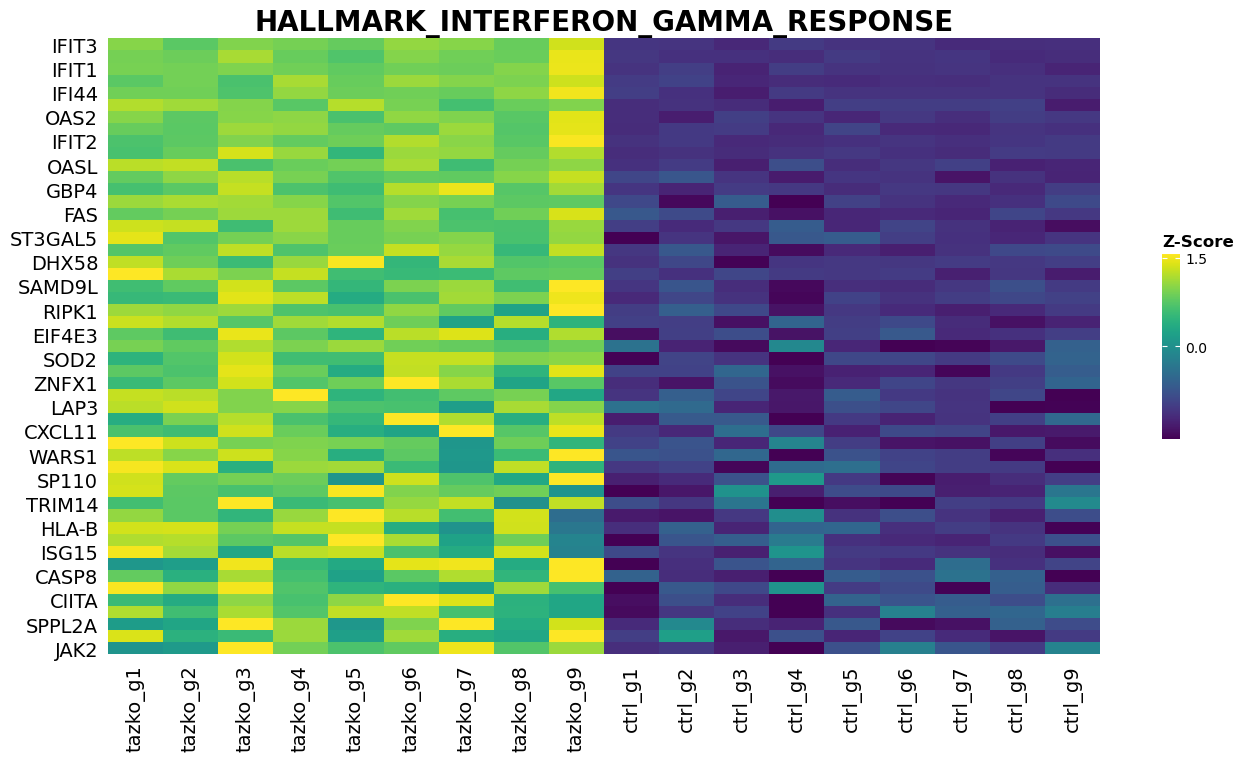

In [13]:
gp.heatmap(df=gs_res.heatmat.loc[genes],
           z_score=0,
           title=gs_res.res2d.Term[2],
           figsize=(16,8),
           cmap='viridis',
          );

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

<h1>Question 5</h1>

1pt

Perform GSEA on direct targets of TAZ using the full class transcriptome dataset with Hallmark gene sets, and pull out the leading edge genes for the top functional group enriched in TAZ KO samples based on their NES. Generate a box-and-whisker plot to visualize the distribution of normalized counts for the leading edge genes for the top functional group. If there are more than 10 leading edge genes, plot up to 10 leading edge genes of your choice from the top functional group.

In [14]:
pip install BioVenn

Note: you may need to restart the kernel to use updated packages.


In [15]:
import BioVenn as bv

In [16]:
peaks = pd.read_csv('../data/annotated-peaks-full-set.txt',
                    sep='\t',
                   )

In [17]:
chip_genes = peaks.loc[peaks['Gene Type'] == 'protein-coding', 'Gene Name']
full_overlap = list(set(norm_counts.gene) & set(chip_genes))

In [18]:
overlap_counts = pd.DataFrame(norm_counts[norm_counts.gene.isin(full_overlap)])

In [19]:
gs_res = gp.GSEA(data=overlap_counts,
                 gene_sets=hallmark_db,
                 classes=class_vector,
                 method='signal_to_noise',
                 permutation_type='phenotype',
                 permutation_num=1000,
                 outdir=None,
                 seed=135,
                )

gs_res.pheno_pos = tazko
gs_res.pheno_neg = ctrl

gs_res.run()

In [20]:
gs_res.res2d.sort_values(by='NES', ascending=False).style

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
4,gsea,HALLMARK_IL2_STAT5_SIGNALING,0.492798,1.394634,0.108911,0.339933,0.391000,9/18,15.55%,TGM2;IFNGR1;BCL2;ETV4;SPRED2;NRP1;PHLDA1;ADAM19;NFKBIZ
9,gsea,HALLMARK_KRAS_SIGNALING_UP,0.391517,1.201898,0.250000,0.380597,0.653000,8/18,10.71%,SATB1;PLAU;ETV4;NRP1;KLF4;DOCK2;DUSP6;CDADC1
12,gsea,HALLMARK_TNFA_SIGNALING_VIA_NFKB,0.300054,0.851600,0.604790,0.652757,0.918000,6/28,7.88%,IFIT2;PLAU;LAMB3;SERPINE1;PTGER4;KLF4
11,gsea,HALLMARK_UV_RESPONSE_DN,-0.299876,-0.901626,0.558824,0.585639,0.902041,12/25,39.39%,ANXA2;ITGB3;RND3;DDAH1;INPP4B;DLG1;PRKCE;LDLR;CCN1;ADGRL2;AKT3;IRS1
10,gsea,HALLMARK_MITOTIC_SPINDLE,-0.424658,-1.139050,0.389662,0.350395,0.702041,11/27,31.09%,SORBS2;FSCN1;WASF2;PALLD;ALS2;DLG1;ACTN4;ARHGAP29;NEDD9;TRIO;MYH9
8,gsea,HALLMARK_APICAL_JUNCTION,-0.430851,-1.274160,0.204040,0.237993,0.525510,15/25,36.76%,LIMA1;LAYN;CDH1;FSCN1;NEGR1;ADRA1B;ACTN1;DLG1;ACTN4;PTPRC;MYH9;TGFBI;MAP3K20;EGFR;AKT3
7,gsea,HALLMARK_ESTROGEN_RESPONSE_LATE,-0.414749,-1.287189,0.164356,0.255784,0.511224,4/15,17.65%,ITPK1;CDH1;PPIF;CCND1
6,gsea,HALLMARK_ESTROGEN_RESPONSE_EARLY,-0.416367,-1.339982,0.147117,0.239612,0.453061,4/24,7.25%,SLC2A1;ITPK1;WWC1;ESRP2
5,gsea,HALLMARK_GLYCOLYSIS,-0.439123,-1.340239,0.148454,0.286913,0.452041,5/15,20.27%,EXT1;PKP2;IGFBP3;COL5A1;LHX9
3,gsea,HALLMARK_INTERFERON_GAMMA_RESPONSE,-0.405813,-1.504724,0.025000,0.152316,0.245918,4/15,15.55%,SLAMF7;PTPN1;BANK1;UPP1


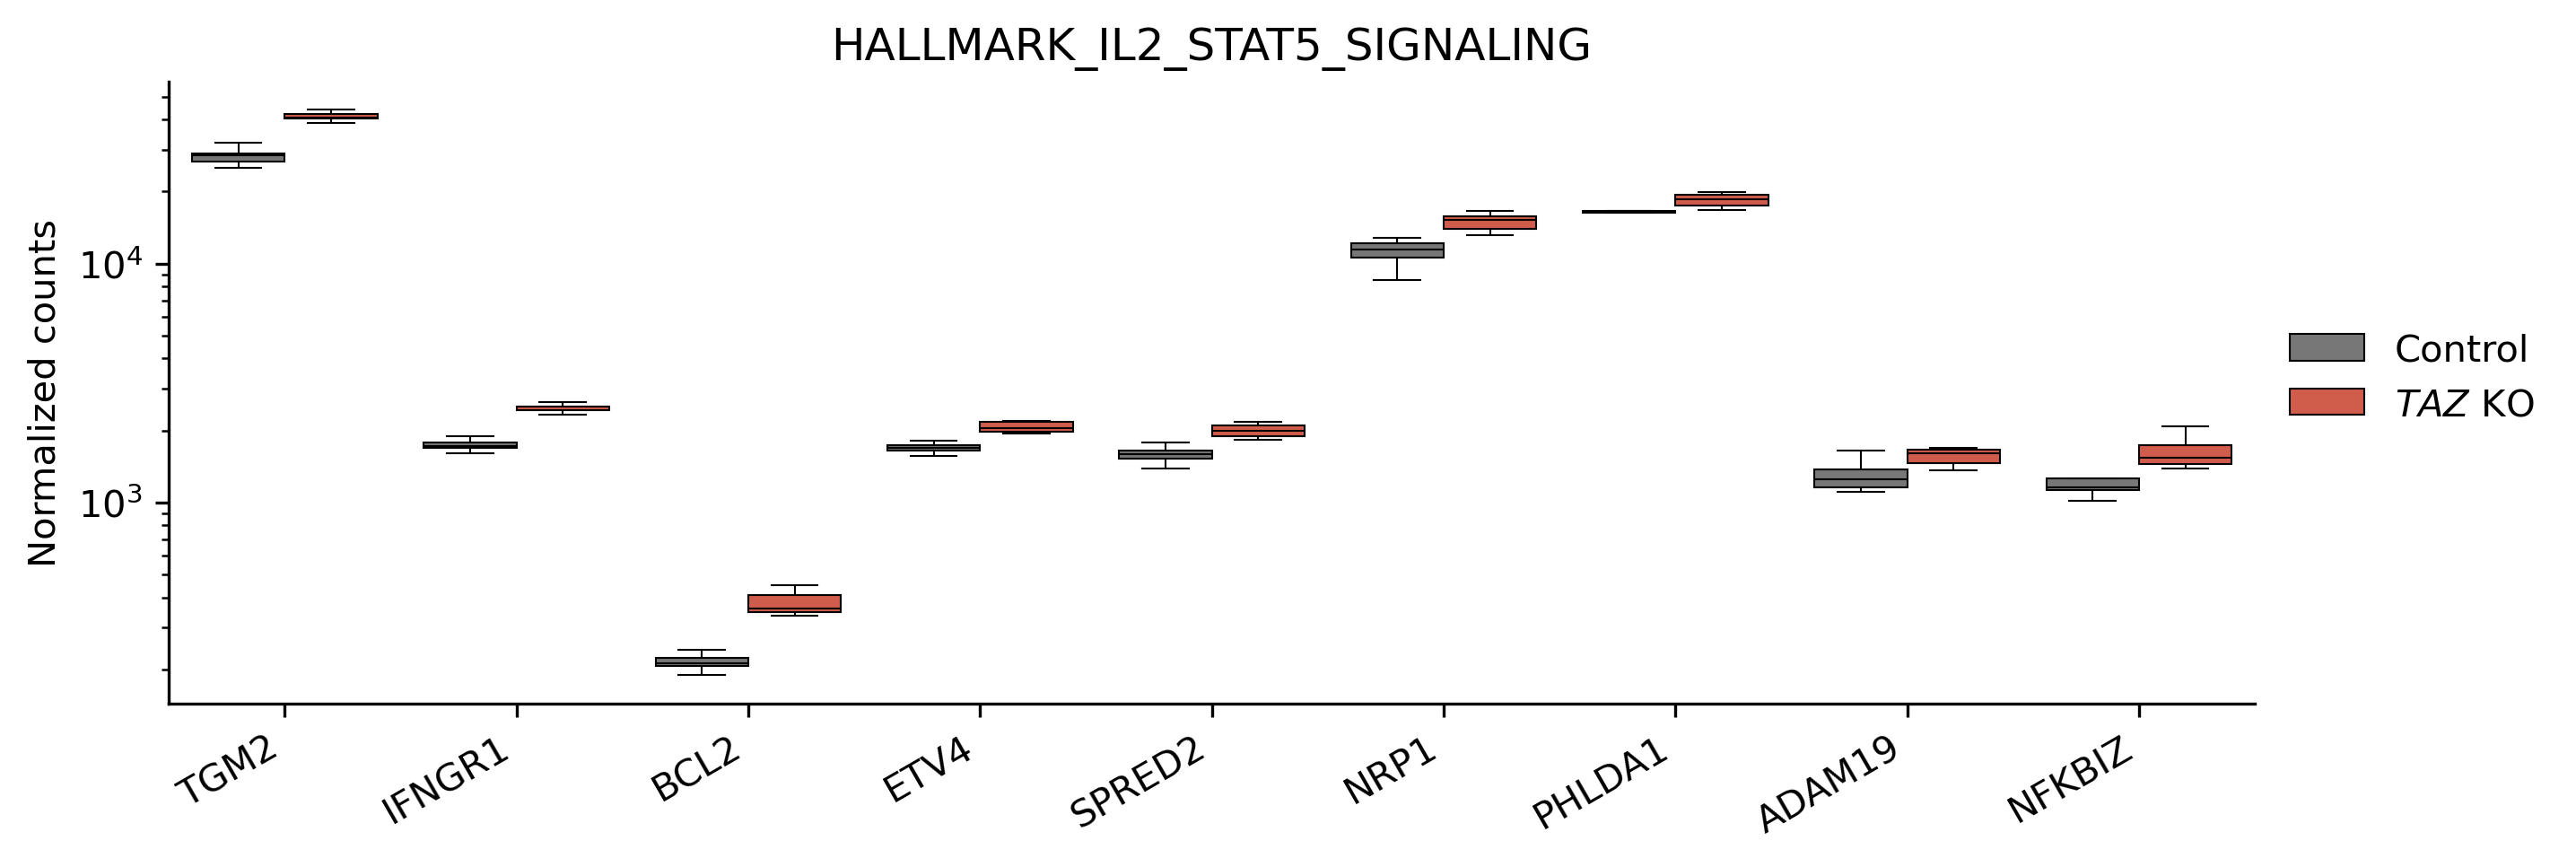

In [21]:
genes = gs_res.res2d.Lead_genes[4].split(';')
IL_genes = gs_res.heatmat.loc[genes]
IL_genes = IL_genes.T
IL_genes.index = ['tazko']*9 + ['control']*9
IL_genes.reset_index(names=['condition'],
                     inplace=True
                    )
IL_genes.sort_values(by='condition', 
                     ascending=True, 
                     inplace=True,
                    )
IL_genes_long = pd.melt(IL_genes,
                        id_vars='condition',
                        value_vars=IL_genes.columns[1:],
                        value_name='count',
                       )

color_set = ['#777777', '#E64B35']
fig, ax = plt.subplots()

sns.boxplot(data=IL_genes_long,
            x='gene',
            y='count',
            hue='condition',
            palette=color_set,
            linewidth=0.5,
            linecolor='k',
            fliersize=False,
            log_scale=False,
           )

handles, labels = ax.get_legend_handles_labels()
labels = ['Control', '$TAZ$ KO']

plt.legend(handles,
           labels,
           bbox_to_anchor=(1.15, 0.25, 0, 0.4),
           edgecolor='None',
          )

ax.set_xlabel(None)
ax.set_ylabel('Normalized counts')
ax.set_title(gs_res.res2d.Term[4])
plt.xticks(rotation=30,
           ha='right',
          )
plt.yscale('log')

sns.despine()
fig.set_dpi(300)
fig.set_size_inches(10, 3)
plt.show()

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>